### 2.1 물체감지

#### 2.1.1 물체 감지 개요
* 바운딩 박스: 물체의 위치를 나타내는 테두리
* 라벨명: 감지된 클래스
* 신뢰도: 얼마나 명확하게 감지했는지

#### 2.1.2 물체 감지 작업의 입력과 출력
* **입력**
     * 이미지
* **출력**
    * 바운딩 박스의 위치와 크기 정보
        * SSD알고리즘: 중심의 좌표(cx, cy), 바운딩박스의 너비(w), 높이(h)로 표현
    * 라벨 정보
        * 감지하려는 물체의 클래스 수(O) + 배경 클래스(1)
    * 신뢰도
        * 각 바운딩 박스와 라벨에 대한 신뢰도

#### 2.1.3 VOC 데이터셋이란
* 클래스: 20종류, 훈련 데이터: 5,717장, 검증데이터: 5,823장
* **각 이미지**마다 **바운딩 박스의 정답 정보**가 있음(어노테이션 정보)
    * xmin, ymin, xmax, ymax, 물체의 클래스를 나타내는 라벨
* 좌측 상단의 원점: (1, 1)

#### 2.1.4 SSD를 활용한 물체 감지 흐름
* SSD
    * DBox를 준비하고 BBox로 변형
    * BBox가 아닌 DBox에서 BBox로 변형시키는 정보 출력
        * **Offset 정보**: DBox를 변형시키는 정보
            * DBox의 정보: (cx_d, cy_d, w_d, h_d)
            * 오프셋 정보: (Δcx, Δcy, Δw, Δh)
    
    
* Step1. 300x300으로 이미지 **resize** + **색 표준화**
    * by **이미지 전처리**
* Step2. 디폴트 박스 8,732개 준비
* Step3. SSD 네트워크에 화상 입력
    * 출력: 디폴트박스(8732개) x (각 클래스의 신뢰도: 21개 + 오프셋: 4개)
* Step4. 신뢰도 높은 디폴트 박스 추출
* Step5. 디폴트 박스를 바운딩 박스로 변형
    * Offset 사용
* Step6. 최종 바운딩 박스와 라벨 출력
    * 신뢰도의 **임계치**

### 2.2 데이터셋 구현

* SSD의 데이터셋 클래스 구현

In [15]:
pip install opencv-python

In [16]:
import os
import urllib.request
import zipfile
import tarfile

In [17]:
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [18]:
weights_dir = "./weights/"
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

In [19]:
url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
target_path = os.path.join(data_dir, "VOCtrainval_11-May-2012.tar") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)
    
    tar = tarfile.TarFile(target_path)
    tar.extractall(data_dir)
    tar.close()
    

In [20]:
url = "https://s3.amazonaws.com/amdegroot-models/vgg16_reducedfc.pth"
target_path = os.path.join(weights_dir, "vgg16_reducedfc.pth") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)

In [21]:
url = "https://s3.amazonaws.com/amdegroot-models/ssd300_mAP_77.43_v2.pth"
target_path = os.path.join(weights_dir, "ssd300_mAP_77.43_v2.pth") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)


#### 2.2.4 화상데이터, 어노테이션 데이터의 파일 경로 리스트 작성
* 이미지 데이터와 어노테이션 데이터의 파일 경로를 리스트형 변수로 생성
* 훈련 및 검증용으로 네 개의 리스트를 작성해야됨
    * (train_img_list, train_anno_list, val_img_list, val_anno_list)
    
    
* **물체 감지**는 화상 데이터와 함께 **어노테이션 데이터를 데이터셋에서 처리**해야됨
* 전처리로 인해 이미지가 변경된다면 어노테이션 정보도 같이 변경해주어야됨

* `xml.etree.ElementTree`
    * XML을 객체화하기 위해서 필요

* 난수시드 설정
    * 난수 seed를 사용하면 동일한 난수 생성 가능
    * **다시 학습하더라도 같은 결과**를 얻을 수 있음

In [22]:
import os.path as osp
import random
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data

In [23]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [24]:
# 학습 및 검증용 화상데이터, 어노테이션 데이터의 파일 경로 리스트 작성
# train.txt와 val.txt를 읽어들여 훈련 및 검증 데이터 각 파일의 ID를 받은 후 이미지와 어노테이션 파일의 경로 리스트를 만든다.
def make_datapath_list(rootpath):
    """
    데이터 경로를 저장한 리스트 작성
    
    Parameters
    ----------
    rootpath : str
        데이터 폴더 경로
        
    Returns
    -------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
        데이터 경로를 저장한 리스트
    """

    # 이미지 파일과 어노테이션 파일의 경로 템플릿 작성
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'Annotations', '%s.xml')

    # 훈련 및 검증 파일 ID(파일 이름) 취득
    train_id_names = osp.join(rootpath + 'ImageSets/Main/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Main/val.txt')

    # 훈련 데이터의 화상 파일과 어노테이션 파일의 경로 리스트 작성
    train_img_list = list()
    train_anno_list = list()

    for line in open(train_id_names):
        file_id = line.strip()  # 공백과 줄 바꿈 제거
        img_path = (imgpath_template % file_id)  # 화상 경로
        anno_path = (annopath_template % file_id)  # 어노테이션 경로
        train_img_list.append(img_path)  # 리스트에 추가
        train_anno_list.append(anno_path)  # 리스트에 추가

    # 검증 데이터의 화상 파일과 어노테이션 파일의 경로 리스트 작성
    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()  # 공백과 줄 바꿈 제거
        img_path = (imgpath_template % file_id)  # 화상 경로
        anno_path = (annopath_template % file_id)  # 어노테이션 경로
        val_img_list.append(img_path)  # 리스트에 추가
        val_anno_list.append(anno_path)  # 리스트에 추가

    return train_img_list, train_anno_list, val_img_list, val_anno_list

In [25]:
# 파일 경로 리스트 작성
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath)

# 동작 확인
print(train_img_list[0])

./data/VOCdevkit/VOC2012/JPEGImages\2008_000008.jpg


#### 2.2.5 xml 형식의 어노테이션 데이터를 리스트로 변환하기
* `Anno_xml2list`클래스
    * xml 데이터를 파이썬 리스트형 변수로 변환
* `ET.parse`
    * xml이 파일형태로 존재하며 xml을 파싱할 때 사용
    * xml에서 특정 태그를 선택할 떄 사용
* `strip()`
    * 문자열 양 끝에 있는 공백제거

#### + xml 파일을 파싱하는 파이썬 코드

```python
# 라이브러리 선언
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import Element, dump, ElementTree

# 파일 불러오기 및 root 노드 선언
xml_file = 'D:\\test.xml'
doc = ET.parse(xml_file)

# root 노드 가져오기
root = doc.getroot()

# xml 태그 중 size 태그 선택
size_tag = root.findall("size")
```
---
```python
# 전체 태그를 선택하여 반복문
# object의 태그를 선택하고 iter로 반복문을 실행하며 태그를 선택
for object in root.iter("object"):
    # findtext로 선택 태그를 입력하여 값을 가져옴
    print(object.find("bndbox").findtext("xmin"))
```

In [26]:
# XML 형식의 어노테이션을 리스트 형식으로 변환하는 클래스
class Anno_xml2list(object):
    """
    한 화상의 XML 형식 어노테이션 데이터를 화상 크기로 규격화하여 리스트 형식으로 변환
    
    Attributes
    ----------
    classes: 리스트
        VOC의 클래스명을 저장하느 리스트
    """
    
    def __init__(self, classes):
        self.classes = classes
    def __call__(self, xml_path, width, height):
        """
        한 화상의 XML형식 어노테이션 데이터를 화상 크기로 규격화하여 리스트 형식으로 변환
        
        Parameters
        ----------
        xml_path: str
            xml 파일 경로
        width: int
            대상 화상 폭
        height: int
            대상 화상 높이
        
        Returns
        -------
        
        ret: [[xmin, ymin, xmax, ymax, label_ind], ...]
            물체의 어노테이션 데이터를 저장한 리스트. 화상에 존재하는 물체 수만 큼의 요소를 가진다.
        """
        
        # 이미지 내 모든 물체의 어노테이션을 이 리스트에 저장
        ret = []
        
        # xml 파일 로드
        xml = ET.parse(xml_path).getroot()
        
        # 화상 내 물체(object) 수만큼 반복
        for obj in xml.iter('object'):
            
            # 어노테이션에서 태그가 difficult로 설정된 것은 제외
            difficult = int(obj.find('difficult').text)
            if difficult == 1:
                continue
            
            # 한 물체의 어노테이션을 저장하는 리스트
            bndbox = []
            
            name = obj.find('name').text.lower().strip()  # 물체 이름
            bbox = obj.find('bndbox')  # 바운딩 박스 정보

            # 어노테이션의 xmin, ymin, xmax, ymax를 취득하고 0~1으로 규격화
            pts = ['xmin', 'ymin', 'xmax', 'ymax']

            for pt in (pts):
                # VOC는 원점이 (1, 1)이므로 1을 빼서 (0, 0)으로 한다.
                cur_pixel = int(bbox.find(pt).text) - 1

                # 폭, 높이로 규격화
                if pt == 'xmin' or pt == 'xmax':  # x 방향의 경우 폭으로 나눈다.
                    cur_pixel /= width
                else:  # y 방향의 경우 높이로 나눈다.
                    cur_pixel /= height

                bndbox.append(cur_pixel)

            # 어노테이션의 클래스명 index를 취득하여 추가
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)

            # res에[xmin, ymin, xmax, ymax, label_ind]를 더한다.
            ret += [bndbox]

        return np.array(ret)  # [[xmin, ymin, xmax, ymax, label_ind], ... ]


In [28]:
# 동작 확인　
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

transform_anno = Anno_xml2list(voc_classes)

# 화상 로드용으로 OpenCV 사용
ind = 1
image_file_path = val_img_list[ind]
img = cv2.imread(image_file_path)  # [높이][폭][색BGR]
height, width, channels = img.shape  # 화상 크기 취득

# 어노테이션을 리스트로 표시
transform_anno(val_anno_list[ind], width, height)

array([[ 0.09      ,  0.03003003,  0.998     ,  0.996997  , 18.        ],
       [ 0.122     ,  0.56756757,  0.164     ,  0.72672673, 14.        ]])

#### 2.2.6 이미지와 어노테이션의 전처리를 실시하는 DataTransform 클래스 작성
* 이미지 변형시 BBox 정보도 함께 변형해야됨
* 이미지와 BBox를 동시에 변형하는 클래스는 파이토치에 없으므로 직접 만들어야 됨

In [29]:
# utils 폴더에 있는 data_augumentation.py에서 import。
# 입력 영상의 전처리 클래스
from utils.data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords, PhotometricDistort, Expand, RandomSampleCrop, RandomMirror, ToPercentCoords, Resize, SubtractMeans


class DataTransform():
    """
    화상과 어노테이션의 전처리 클래스. 훈련과 추론에서 다르게 작동한다.
    화상 크기를 300x300으로 한다.
    학습 시 데이터 확장을 수행한다.

    Attributes
    ----------
    input_size : int
        리사이즈 대상 이미지의 크기
    color_mean : (B, G, R)
        각 색상 채널의 평균값
    """

    def __init__(self, input_size, color_mean):
        self.data_transform = {
            # 훈련 시의 데이터 확장
            # 색 변환, 이미지 크기 변경, 리사이즈, 색상 정보의 평균값 빼기
            'train': Compose([
                ConvertFromInts(),  # int를 float32로 변환
                ToAbsoluteCoords(),  # 어노테이션 데이터의 규격화 반환
                PhotometricDistort(),  # 화상의 색조 등 임의로 변화
                Expand(color_mean),  # 이미지의 캔버스 확대
                RandomSampleCrop(),  # 이미지 내의 특정 부분 무작위 추출
                RandomMirror(),  # 이미지 반전
                ToPercentCoords(),  # 어노테이션 데이터를 0~1로 규격화
                Resize(input_size),  # 이미지 크기를 inputxinput_size로 변형
                SubtractMeans(color_mean)  # BGR색상의 평균값 빼기
            ]),
            # 추론 시에는 이미지의 크기를 변환하고 색상의 평균값을 뺌
            'val': Compose([
                ConvertFromInts(),  # int를 float로 변환
                Resize(input_size),  # 이미지 크기를 input_size×input_size로 변형
                SubtractMeans(color_mean)  # BGR색상의 평균값 빼기
            ])
        }

    def __call__(self, img, phase, boxes, labels):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            전처리 모드 지정。
        """
        return self.data_transform[phase](img, boxes, labels)


#### DataTransform 클래스의 동작 확인
* 원본 이미지
* 전처리로 변화된 훈련 시 이미지
* 전처리로 변화된 검증 시 이미지
* `anno_list[:, :4]`
    * 어노테이션 데이터 BBox의 좌표 정보
* `anno_list[:, 4]`
    * 물체의 클래스명에 대응하는 인덱스 정보
* `cvtColor`


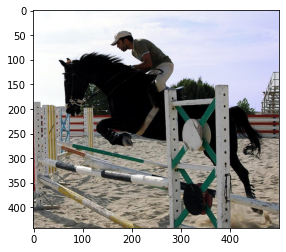

C:\Users\kodhd\pytorch_learning\Chapter2. 물체감지(SSD)\utils\data_augumentation.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


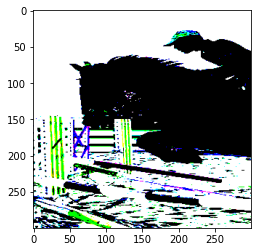

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


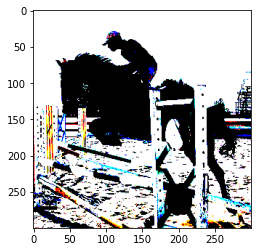

[[ 52.  86. 470. 419.]
 [157.  43. 288. 166.]]
[12. 14.]


In [30]:
# 동작 확인

# 1. 화상 읽기
image_file_path = train_img_list[0]
img = cv2.imread(image_file_path)  # [높이][폭][색BGR]
height, width, channels = img.shape  # 이미지 크기 취득

# 2. 어노테이션을 리스트로
transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno(train_anno_list[0], width, height)

# 3. 원본 표시
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 4. 전처리 클래스 작성
color_mean = (104, 117, 123)  # (BGR) 색상의 평균값
input_size = 300  # 이미지의 input 사이즈를 300×300으로
transform = DataTransform(input_size, color_mean)

# 5. train이미지 표시 (훈련이미지)
phase = "train"
img_transformed, boxes, labels = transform(img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()


# 6. val이미지 표시 (검증이미지)
phase = "val"
img_transformed, boxes, labels = transform(img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()
         
# 어노테이션 데이터 BBox의 좌표 정보
print(anno_list[:, :4])

# 물체의 클래스명에 대응하는 인덱스 정보
# 12: horse, 14: people
print(anno_list[:, 4])


#### 2.2.7 데이터셋 작성
* 파이토치의 Dataset 클래스를 상속받아 VOCDataset클래스 생성
* `Anno_xml2list`클래스, `DataTransform`클래스 활용
* `__getitem__()`
    * 전처리한 이미지의 텐서 형식 데이터와 어노테이션 획득

In [31]:
# VOC2012의 Dataset작성
class VOCDataset(data.Dataset):
    """
    VOC2012의 Dataset을 만드는 클래스. PyTorch의 Dataset 클래스를 상속한다.

    Attributes
    ----------
    img_list : 리스트
        이미지 경로를 저장한 리스트
    anno_list : 리스트
        어노테이션 경로를 저장한 리스트
    phase : 'train' or 'test'
        학습 또는 훈련 설정
    transform : object
        전처리 클래스의 인스턴스
    transform_anno : object
        xml 어노테이션을 리스트로 변환하는 인스턴스
    """

    def __init__(self, img_list, anno_list, phase, transform, transform_anno):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase  # train 또는 val 지정
        self.transform = transform  # 이미지 변형
        self.transform_anno = transform_anno  # 어노테이션 데이터를 xml에서 리스트로 변경

    def __len__(self):
        '''이미지의 매수 반한'''
        return len(self.img_list)

    def __getitem__(self, index):
        '''
        전처리한 이미지의 텐서 형식 데이터와 어노테이션 취득
        '''
        im, gt, h, w = self.pull_item(index)
        print(im.size())
        return im, gt

    def pull_item(self, index):
        '''
        전처리한 이미지의 텐서 형식 데이터, 어노테이션, 화상의 높이, 폭 취득
        '''
        # 1. 이미지의 매수 반환
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)  # [높이][폭][색BGR]
        height, width, channels = img.shape  # 화상 크기 취득

        # 2. xml 형식의 어노테이션 정보를 리스트에 저장
        anno_file_path = self.anno_list[index]
        anno_list = self.transform_anno(anno_file_path, width, height)

        # 3. 전처리 실시
        img, boxes, labels = self.transform(img, self.phase, anno_list[:, :4], anno_list[:, 4])

        # 색상 채널의 순서가 BGR이므로 RGB로 순서 변경
        # (높이, 폭, 색상 채널)의 순서를 (색상 채널, 높이, 폭)으로 변경
        img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)

        # BBox와 라벨을 세트로 한 np.array를 작성. 변수 이름 gt는 ground truth의 약칭
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))

        return img, gt, height, width


#### Dataset 동작 확인

In [32]:
# 동작 확인
color_mean = (104, 117, 123)  # (BGR)의 색의 평균값
input_size = 300  # 이미지의 input 사이즈를 300x300으로 한다.

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))


# 데이터 출력 예
# 전처리한 화상의 텐서 형식 데이터와 어노테이션 취득
val_dataset.__getitem__(1)

(tensor([[[   0.9417,    6.1650,   11.1283,  ...,  -22.9083,  -13.2200,
             -9.4033],
          [   6.4367,    9.6600,   13.8283,  ...,  -21.4433,  -18.6500,
            -18.2033],
          [  10.8833,   13.5500,   16.7000,  ...,  -20.9917,  -24.5250,
            -25.1917],
          ...,
          [ -23.9500,  -14.9000,   -1.7583,  ..., -108.6083, -111.0000,
           -117.8083],
          [ -28.2817,  -20.1750,   -5.5633,  ..., -104.9933, -111.8350,
           -119.0000],
          [ -20.4767,  -21.0000,  -12.6333,  ..., -107.1683, -115.7800,
           -117.1100]],
 
         [[  25.9417,   30.1650,   35.1283,  ...,  -18.0767,  -14.7250,
            -11.8533],
          [  31.4367,   33.6600,   37.8283,  ...,  -13.5017,  -10.8250,
            -10.3783],
          [  35.7917,   37.5500,   40.7000,  ...,  -11.8417,  -13.0750,
            -14.0167],
          ...,
          [  -1.9500,    7.1000,   20.2417,  ..., -101.9083, -102.0000,
           -109.7167],
          [  -6.2

### 2.3 데이터 로더 구현

#### 2.3.1 데이터 로더 작성
* DataLoader Class
    * batch 기반의 딥러닝 모델 학습을 위해 mini batch를 만들어줌
    * DataLoader를 통해 dataset의 전체 데이터가 batch size로 slice 됨
    * dataset을 input으로 넣어주면 여러 옵션을 통해 batch를 만들어줌
    
    
* 물체 감지용 DataLoader
    * SSD의 학습 및 추론 시 데이터로 미니 배치로 꺼내줌
    * 데이터마다 Dataset에서 꺼내는 변수의 크기가 다름
        * 이미지 데이터마다 Dataset에서 사용할 어노테이션 데이터 정보, gt 변수의 크기(이미지 내의 물체 수)가 다름
        * `collate_fn` 생성
        
    * `gt`: 리스트형 변수
    * 요소 수: 이미지 속 물체의 수
    * 각 요소: 다섯 개의 변수 `[xmin, ymin, xmax, ymax, class_index]`
    
    
* `od_collate_fn` 함수 사용
    * 데이터 추출 함수
    
    
* stack 함수
    * 지정하는 차원으로 확장하여 tensor를 쌓아주는 함수
    * 두 tensor의 차원이 정확히 일치해야 쌓을 수 있다!
----
* Dataset의 `__getitem__`이 매번 다른 길이(shape)의 텐서를 리턴하는 경우, batch_size를 2 이상으로 하기 위해 `collate_fn`함수를 작성해야된다고 한다,,,,, 

In [44]:
def od_collate_fn(batch):
    """
    Dataset에서 꺼내는 어노테이션 데이터의 크기는 화상마다 다르다.
    화상 내의 물체 수가 두 개이면 (2, 5) 사이즈이지만 세 개이면 (3, 5) 등으로 바뀐다.
    변화에 대응하는 DataLoader를 만드는 collate_fn을 작성한다.
    collate_fn은 파이토치 리스트로 mini-batch를 작성하는 함수이다.
    미니 배치 분량의 화상이 나열된 리스트 변수 batch에 미니 배치 번호를 지정하는
    차원을 가장 앞에 하나 추가하여 리스트 형태를 변형한다.
    """

    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])  # sample[0]은 이미지 img
        targets.append(torch.FloatTensor(sample[1]))  # sample[1]은 어노테이션 gt

    # imgs는 미니 배치 크기의 리스트
    # 리스트 요소는 torch.Size([3, 300, 300])
    # 이 리스트를 torch.Size([batch_num, 3, 300, 300])의 텐서로 변환
    imgs = torch.stack(imgs, dim=0)

    # targets은 어노테이션의 정답인 gt 리스트
    # 리스트 크기 = 미니 배치 크기
    # targets 리스트의 요소는 [n, 5]
    # n은 이미지마다 다르며 이미지 속 물체의 수
    # 5는 [xmin, ymin, xmax, ymax, class_index]

    return imgs, targets


In [62]:
# 데이터로더 작성
batch_size = 4

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

# 사전형 변수에 정리
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 동작 확인
batch_iterator = iter(dataloaders_dict["val"])  # 반복자로 변환
images, targets = next(batch_iterator)  # 첫 번쨰 요소 추출

# torch.Size([4, 3, 300, 300])
# (미니 배치 수, 색상 채널, 높이, 폭)
print(images.size())
print(len(targets))

# 미니 배치 크기의 리스트, 각 요소: [n 5]
# target에는 어노테이션 정보가 있음
# n은 물체 수
print(targets[1].size())
print(targets[1])

torch.Size([3, 300, 300])
torch.Size([3, 300, 300])
torch.Size([3, 300, 300])
torch.Size([3, 300, 300])
torch.Size([4, 3, 300, 300])
4
torch.Size([2, 5])
tensor([[ 0.0900,  0.0300,  0.9980,  0.9970, 18.0000],
        [ 0.1220,  0.5676,  0.1640,  0.7267, 14.0000]])


In [199]:
# 데이터 수 확인
print(train_dataset.__len__())
print(val_dataset.__len__())

5717
5823


### 2.4 네트워크 모델 구현

* SSD 네트워크 모델
    * 입력
        * 전처리된 이미지 데이터
    * 출력
        * 8732개의 DBox에 대한 오프셋 정보
        * 각 클래스에 대한 21종류의 신뢰도
        
        
* SSD 주요 서브 네트워크
    * vgg
    * extra
    * loc
    * conf

#### 2.4.2 vgg 모듈 구현

In [155]:
from math import sqrt
from itertools import product

import pandas as pd
import torch
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

* vgg 모듈 구현
    * 각 합성곱 층의 채널 수와 최대 풀링 층의 정보를 구성변수로 하여 그 요소의 값에 따라 유닛을 만듦
        * 구성변수: `cfg = [64, 64, 'M', ...]`

In [156]:
# 34 층에 걸친 vgg 모듈 작성
def make_vgg():
    layers = []
    in_channels = 3  # 색 채널 수

    # vgg 모듈에서 사용하는 합성곱 층이나 최대 풀링 채널 수
    # 'M: 최대 풀링 층
    # 'MC': ceil 모드의 최대 풀링 층
    cfg = [64, 64, 'M', 128, 128, 'M', 256, 256,
           256, 'MC', 512, 512, 512, 'M', 512, 512, 512]

    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'MC':
            # ceil은 계산 결과(float)에서 출력 크기의 소수점을 올려 정수로 하는 모드
            # 디폴트는 계산 결과(float)에서 출력 크기의 소수점을 버려 정수로 하는 floor 모드
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
        else:
            # ReLU인수 inplace: ReLU에 대한 입력을 메모리 상에 유지할 것인지 입력을 재작성할 것인지 결정
            # inplace = True: ouput이 낭지 않고 input값이 갱신
            layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
    conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    layers += [pool5, conv6,
               nn.ReLU(inplace=True), conv7, nn.ReLU(inplace=True)]
    return nn.ModuleList(layers)


# 동작확인
vgg_test = make_vgg()
print(vgg_test)


ModuleList(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1

#### 2.4.3 extra 모듈 구현
* ReLU를 SSD 모델의 순전파 함수 내에서 준비하고 extra모듈에서는 사용X

In [157]:
# 8층에 걸친 extra 모듈 작성
def make_extras():
    layers = []
    in_channels = 1024  # vgg 모듈에서 출력된 extra에 입력되는 이미지 채널 수

    # extra 모듈의 합성곱 층 채널 수를 설정하는 구성
    cfg = [256, 512, 128, 256, 128, 256, 128, 256]

    layers += [nn.Conv2d(in_channels, cfg[0], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[0], cfg[1], kernel_size=(3), stride=2, padding=1)]
    layers += [nn.Conv2d(cfg[1], cfg[2], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[2], cfg[3], kernel_size=(3), stride=2, padding=1)]
    layers += [nn.Conv2d(cfg[3], cfg[4], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[4], cfg[5], kernel_size=(3))]
    layers += [nn.Conv2d(cfg[5], cfg[6], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[6], cfg[7], kernel_size=(3))]
    
    # 활성화 함수의 ReLU는 이번에는 SSD모듈의 순전파에서 준비하고
    # extra모듈에서는 준비하지 않는다.
    return nn.ModuleList(layers)


# 동작확인
extras_test = make_extras()
print(extras_test)


ModuleList(
  (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
  (1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (2): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
  (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (6): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
)


#### 2.4.4 loc 및 conf 모듈 구현
* `make_loc_conf`
    * `loc`와 `conf`를 구현
    * `loc_layer`
        * 디폴트박스의 오프셋을 출력
    * `conf_layers`
        * 디폴트박스의 각 클래스 신뢰도를 출력
        
        
* `bbox_aspect_num`: 각 소스로 사용하는 DBox의 수

In [158]:
# 디폴트 박스의 오프셋을 출력하는 loc_layers와
# 디폴트 박스의 각 클래스 신뢰도 confidence를 출력하는 conf_layers 작성
def make_loc_conf(num_classes=21, bbox_aspect_num=[4, 6, 6, 6, 4, 4]):

    loc_layers = []
    conf_layers = []

    # VGG 22층, conv4_3(source1)의 합성곱 층
    loc_layers += [nn.Conv2d(512, bbox_aspect_num[0] * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(512, bbox_aspect_num[0] * num_classes, kernel_size=3, padding=1)]

    # VGG 최종층(source2)의 합성곱 층
    loc_layers += [nn.Conv2d(1024, bbox_aspect_num[1] * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(1024, bbox_aspect_num[1] * num_classes, kernel_size=3, padding=1)]

    # extra(source3)의 합성곱 층
    loc_layers += [nn.Conv2d(512, bbox_aspect_num[2] * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(512, bbox_aspect_num[2] * num_classes, kernel_size=3, padding=1)]

    # extra(source4)의 합성곱 층
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[3] * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[3] * num_classes, kernel_size=3, padding=1)]

    # extra(source5)의 합성곱 층
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[4] * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[4] * num_classes, kernel_size=3, padding=1)]

    # extra(source6)의 합성곱 층
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[5] * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[5] * num_classes, kernel_size=3, padding=1)]

    return nn.ModuleList(loc_layers), nn.ModuleList(conf_layers)

# 동작확인
loc_test, conf_test = make_loc_conf()
print(loc_test)
print(conf_test)


ModuleList(
  (0): Conv2d(512, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
ModuleList(
  (0): Conv2d(512, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


#### 2.4.5 L2Norm 층 구현

* L2Norm 층
    * conv_4_3의 출력에 쓰임
    * 특정량 맵의 통계적 특성이 채널마다 다른 점을 정규화,,,
    * L2Norm 층에 대한 입력(512채널⨉32⨉32) 텐서를 38⨉32개의 셀에 대해 512 채널에 걸쳐 정규화,,,

In [159]:
# convC4_3의 출력을 scale = 20의 L2Norm으로 정규화하는 층
class L2Norm(nn.Module):
    def __init__(self, input_channels=512, scale=20):
        super(L2Norm, self).__init__()  # 부모 클래스의 생성자 실행
        self.weight = nn.Parameter(torch.Tensor(input_channels))
        self.scale = scale  # 계수 weight의 초기값으로 설정할 값
        self.reset_parameters()  # 파라미터 초기화
        self.eps = 1e-10

    def reset_parameters(self):
        '''결합 파라미터의 scale 크기 값으로 초기화 실행'''
        init.constant_(self.weight, self.scale)  # weight 값이 모두 scale(=20)이 된다.

    def forward(self, x):
        '''
        38×38의 특징량에 대해 512 채널에 걸쳐 제곱합의 루트를 구했다.
        38×38개의 값을 사용하여 각 특징량을 정규화한 후 계수를 곱하여 계산하는 층
        '''

        # 각 채널의 38x38개 특징량의 채널 방향 제곱합을 계산하고
        # 루트를 구해 나누어 정규화한다.
        # norm의 텐서 사이즈는 torch.Size([batch_num, 1, 38, 38])
        norm = x.pow(2).sum(dim=1, keepdim=True).sqrt()+self.eps
        x = torch.div(x, norm)

        # 계수를 곱한다. 계수는 채널마다 하나로 512개의 계수를 갖는다.
        # self.weight의 텐서 사이즈는 torch.Size([512])로
        # torch.Size([batch_num, 512, 38, 38])까지 변형한다.
        weights = self.weight.unsqueeze(
            0).unsqueeze(2).unsqueeze(3).expand_as(x)
        out = weights * x

        return out

#### 2.4.6 디폴트 박스 구현

* source1~6까지 크기가 다른 특징량 맵에 대해 각각 4 또는 6 종류의 DBox 생성
    * 4종류
        * 작은 정사각형, 큰 정사각형, 1:2 비율의 직사각형, 2:1 비율의 직사각형
    * 6종류
        * + 3:1 비율의 직사각형, 1:3 비율의 직사각형
* `for i, j in product(...)`: 조합을 출력하는 명령어
    * 조합을 활용하여 DBox의 중심 좌표 작성
        * 8732행 4열(cx, cy, w, h)의 표
* `torch.tensor().view`: Tensor 자료형의 사이즈 및 차원 변경시 사용

In [160]:
# 디폴트박스를 출력하는 클래스
class DBox(object):
    def __init__(self, cfg):
        super(DBox, self).__init__()

        # 초기설정
        self.image_size = cfg['input_size']  # 이미지의 크기: 300
        # [38, 19, …] 각 소스의 특징량 맵의 크기
        self.feature_maps = cfg['feature_maps']
        # 소스의 개수: 6
        self.num_priors = len(cfg["feature_maps"])
        # [8, 16, …] DBox의 픽셀 크기
        self.steps = cfg['steps'] 
        
        # [30, 60, ...] 작은 정사각형의 DBox 피셀 크기(정확히는 면적)
        self.min_sizes = cfg['min_sizes']
        
        # [60, 111, ...] 큰 정사각형의 DBox 픽셀 크기(정확히는 면적)
        self.max_sizes = cfg['max_sizes']
        
        # 정사각형의 DBox 화면비(종횡비)
        self.aspect_ratios = cfg['aspect_ratios']

    def make_dbox_list(self):
        '''DBox 작성'''
        mean = []
        # 'feature_maps': [38, 19, 10, 5, 3, 1]
        for k, f in enumerate(self.feature_maps):
            for i, j in product(range(f), repeat=2):  # f까지의 수로 두 쌍의 조합을 작성. f_P_2개
                # 특징량의 이미지 크기
                # 300 / 'steps': [8, 16, 32, 64, 100, 300],
                f_k = self.image_size / self.steps[k]

                # DBox의 중심 좌표 x, y. 0~1로 정규화되어 있다.
                cx = (j + 0.5) / f_k
                cy = (i + 0.5) / f_k

                # 화면비 1의 작은 DBox [cx,cy, width, height]
                # 'min_sizes': [30, 60, 111, 162, 213, 264]
                s_k = self.min_sizes[k]/self.image_size
                mean += [cx, cy, s_k, s_k]

                # 화면비 1의 큰 DBox [cx,cy, width, height]
                # 'max_sizes': [60, 111, 162, 213, 264, 315],
                s_k_prime = sqrt(s_k * (self.max_sizes[k]/self.image_size))
                mean += [cx, cy, s_k_prime, s_k_prime]

                # 그 외 화면비의 defBox [cx,cy, width, height]
                for ar in self.aspect_ratios[k]:
                    mean += [cx, cy, s_k*sqrt(ar), s_k/sqrt(ar)]
                    mean += [cx, cy, s_k/sqrt(ar), s_k*sqrt(ar)]

        # DBox를 텐서로 변환 torch.Size([8732, 4])
        output = torch.Tensor(mean).view(-1, 4)

        # DBox가 화상 밖으로 돌출되는 것을 막기 위해 크기를 최소: 0, 최대: 1로 한다.
        output.clamp_(max=1, min=0)

        return output


In [161]:
# 동작확인
# DBox의 좌표 정보 표 출력

# SSD300 설정
ssd_cfg = {
    'num_classes': 21,  # 배경 클래스를 포함한 총 클래스 수
    'input_size': 300,  # 입력 이미지 크기
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 출발할 Box 화면비 종류
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 각 source 이미지 크기
    'steps': [8, 16, 32, 64, 100, 300],  # DBOX크기를 정한다.
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOX크기
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOX크기
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]], # 정사각형의 DBox 화면비
}

# DBox 작성
dbox = DBox(ssd_cfg)
dbox_list = dbox.make_dbox_list()

# DBox 출력 확인
pd.DataFrame(dbox_list.numpy())

# 결과: 8732행 4열(cx, cy, w, h)의 표

,0,1,2,3
0,0.013333,0.013333,0.100000,0.100000
1,0.013333,0.013333,0.141421,0.141421
2,0.013333,0.013333,0.141421,0.070711
3,0.013333,0.013333,0.070711,0.141421
4,0.040000,0.013333,0.100000,0.100000
...,...,...,...,...
8727,0.833333,0.833333,0.502046,1.000000
8728,0.500000,0.500000,0.880000,0.880000
8729,0.500000,0.500000,0.961249,0.961249
8730,0.500000,0.500000,1.000000,0.622254


#### 2.4.7 SSD 클래스 구현
* SSD 클래스
    * 훈련과 추론 시 다르게 동작
    * 추론
        * Detect 클래스 사용
* `nn.Module`


In [200]:
# SSD 클래스 작성
class SSD(nn.Module):

    def __init__(self, phase, cfg):
        super(SSD, self).__init__()

        self.phase = phase  # train or inference 지정
        self.num_classes = cfg["num_classes"]  # 클래스 수: 21

        # SSD 네크워크 작성
        self.vgg = make_vgg()
        self.extras = make_extras()
        self.L2Norm = L2Norm()
        self.loc, self.conf = make_loc_conf(cfg["num_classes"], cfg["bbox_aspect_num"])

        # DBOX 작성
        dbox = DBox(cfg)
        self.dbox_list = dbox.make_dbox_list()

        # 추론 시 Detect 클래스 준비
        if phase == 'inference':
            self.detect = Detect()

In [201]:
# 동작확인
ssd_test = SSD(phase="train", cfg=ssd_cfg)
print(ssd_test)

SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (17): Conv2d(256, 

------

In [163]:
# 오프셋 정보로 DBox를 BBox로 변환하는 함수
def decode(loc, dbox_list):
    """
    오프셋 정보로 DBox를 BBox로 변환한다.
    
    Parameters
    ----------
    loc:  [8732,4]
        SSD 모델로 추론하는 오프셋 정보
    dbox_list: [8732,4]
        DBox 정보

    Returns
    -------
    boxes : [xmin, ymin, xmax, ymax]
        BBox 정보
    """

    # DBox눈 [cs, cy, width, height]로 저장되었다.
    # loc도 [Δcx, Δcy, Δwidth, Δheight]로 저장되었다.

    # 오프셋 정보로 BBox를 구한다.
    boxes = torch.cat((
        dbox_list[:, :2] + loc[:, :2] * 0.1 * dbox_list[:, 2:],
        dbox_list[:, 2:] * torch.exp(loc[:, 2:] * 0.2)), dim=1)
    # boxes 크기는 torch.Size([8732, 4])가 된다.

    # BBox의 좌표 정보를 [cx, cy, width, height]에서 [xmin, ymin, xmax, ymax] 으로 변경
    boxes[:, :2] -= boxes[:, 2:] / 2  # 좌표(xmin,ymin)로 변환
    boxes[:, 2:] += boxes[:, :2]  # 좌표(xmax,ymax)로 변환

    return boxes


In [179]:
# Non-Maximum Suppression을 실시하는 함수
def nm_suppression(boxes, scores, overlap=0.45, top_k=200):
    """
    Non-Maximum Suppression을 실시하는 함수
    boxes 중 겹치는 (overlap)이상 BBox 삭제

    Parameters
    ----------
    boxes : [신뢰도 임계값（0.01을 넘는 BBox 수, 4]
        BBox情報。
    scores :[신뢰도 임계값（0.01)을 넘는 BBox 수]
        confの情報

    Returns
    -------
    keep : 리스트
        conf의 내림차순으로 nms를 통과한 index 저장
    count：int
        nms를 통과한 BBox 수
    """

    # return 모형 작성
    count = 0
    keep = scores.new(scores.size(0)).zero_().long()
    # keep：torch.Size([신뢰도 임곗값을 넘은 BBox 수])、요소는 전부 0

    # 각 BBox의 면적 area계산
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)

    # boxes 복사. 나중에 BBox 중복도(IOU) 계산 시 모형으로 준비
    tmp_x1 = boxes.new()
    tmp_y1 = boxes.new()
    tmp_x2 = boxes.new()
    tmp_y2 = boxes.new()
    tmp_w = boxes.new()
    tmp_h = boxes.new()

    # score를 오름차순으로 나열
    v, idx = scores.sort(0)

    # 상위 top_k(200개)의 BBox index를 꺼낸다(200개가 존재하지 않는 경우도 있다).
    idx = idx[-top_k:]

    # idx의 요소 수가 0이 아닌 한 루프한다.
    while idx.numel() > 0:
        i = idx[-1]  # conf의 최대 index를 i로

        # keep의 끝에 conf 최대 index 저장
        # 이 index의 BBox와 크게 겹치는 BBox 삭제
        keep[count] = i
        count += 1

        # 마지막 BBox는 루프를 빠져나온다.
        if idx.size(0) == 1:
            break

        # 현재 conf  최대의 index를 keep에 저장했으므로 idx를 하나 감소시킨다.
        idx = idx[:-1]

        # -------------------
        # 지금부터 keep에 저장한 BBox와 크게 겹치는 BBox를 추출하여 삭제
        # -------------------
        # 하나 감소시킨 idx까지의 BBox를 out으로 지정한 변수로 작성
        torch.index_select(x1, 0, idx, out=tmp_x1)
        torch.index_select(y1, 0, idx, out=tmp_y1)
        torch.index_select(x2, 0, idx, out=tmp_x2)
        torch.index_select(y2, 0, idx, out=tmp_y2)

        # 모든 BBox를 현재 BBox = index가 i로 겹치는 값까지로 설정(clamp)
        tmp_x1 = torch.clamp(tmp_x1, min=x1[i])
        tmp_y1 = torch.clamp(tmp_y1, min=y1[i])
        tmp_x2 = torch.clamp(tmp_x2, max=x2[i])
        tmp_y2 = torch.clamp(tmp_y2, max=y2[i])

        # w와 h의 텐서 크기를 index 하나 줄인 것으로 한다.
        tmp_w.resize_as_(tmp_x2)
        tmp_h.resize_as_(tmp_y2)

        # clamp한 상태에서 BBox의 폭과 높이를 구한다.
        tmp_w = tmp_x2 - tmp_x1
        tmp_h = tmp_y2 - tmp_y1

        # 폭이나 높이가 음수인 것은 0으로 한다.
        tmp_w = torch.clamp(tmp_w, min=0.0)
        tmp_h = torch.clamp(tmp_h, min=0.0)

        # clamp된 상태의 면적을 구한다.
        inter = tmp_w*tmp_h

        # IoU = intersect부분 / (area(a) + area(b) - intersect부분) 계산
        rem_areas = torch.index_select(area, 0, idx)  # 각 BBox의 원래 면적
        union = (rem_areas - inter) + area[i]  # 두 구역의 합(OR) 면적
        IoU = inter/union

        # IoU가 overlap보더 작은 idx만 남긴다.
        idx = idx[IoU.le(overlap)]  # le은 Less than or Equal to 처리를 하는 연산
        # IoU가 overlap보다 큰 idx는 처음 선택한 keep에 저장한 idx와 동일한 물체에 BBox를 둘러싸고 있어 삭제

    # while루프에서 빠져나오면 종료

    return keep, count


In [180]:
# SSD 추론 시, conf와 loc의 출력에서중복을 제거한 BBox 출력
class Detect(Function):

    def __init__(self, conf_thresh=0.01, top_k=200, nms_thresh=0.45):
        self.softmax = nn.Softmax(dim=-1)  # conf를 소프트맥스 함수로 정규화하기 위해 준비
        self.conf_thresh = conf_thresh  # conf가 conf_thresh = 0.01보다 높은 DBox만 취급
        self.top_k = top_k  # conf가 높은 top_k개를 nm_superssion으로 계산에 사용하는 top_k = 200
        self.nms_thresh = nms_thresh  # nm_supression으로 IOU가 nms_thresh = 0.45보다 크면 동일한 물체의 BBox로 간주

    def forward(self, loc_data, conf_data, dbox_list):
        """
        순전파 계싼 실행
        
        Parameters
        ----------
        loc_data:  [batch_num,8732,4]
            오프셋 정보
        conf_data: [batch_num, 8732,num_classes]
            감지 신뢰도
        dbox_list: [8732,4]
            DBox 정보

        Returns
        -------
        output : torch.Size([batch_num, 21, 200, 5])
            （batch_num、클래스、conf의 top200、BBox 정보）
        """

        # 각 크기 취득
        num_batch = loc_data.size(0)  # 미니 배치 크기
        num_dbox = loc_data.size(1)  # DBox 수 = 8732
        num_classes = conf_data.size(2)  # 클래스 수 = 21

        # conf는 소프트맥스를 적용하여 정규화
        conf_data = self.softmax(conf_data)

        # 출력 형식을 작성. 텐서 크기 [minibatch수, 21, 200, 5]
        output = torch.zeros(num_batch, num_classes, self.top_k, 5)

        # cof_data 순서를 [batch_num, 8732, num_classes]에서 [batch_num, num_classes, 8732로 변경]
        conf_preds = conf_data.transpose(2, 1)

        # 미니 배치마다 루프
        for i in range(num_batch):

            # 1. loc와 DBox로 수정한 BBox [xmin, ymin, xmax, ymax]를 구한다.
            decoded_boxes = decode(loc_data[i], dbox_list)

            # conf의 복사본 작성
            conf_scores = conf_preds[i].clone()

            # 이미지 클래스별 루프(배경 클래스의 index인 0은 계산하지 않고 index = 1부터)
            for cl in range(1, num_classes):

                # 2.conf의 임곗값을 넘은 BBox를 꺼낸다.
                # conf의 임곗값을 넘고 있는지 마스크를 작성하여
                # 임곗값을 넘은 conf의 인덱스를 c_mask로 취득
                c_mask = conf_scores[cl].gt(self.conf_thresh)
                # gt는 Grater than을 의미. gt로 임곗값이 넘으면 1, 이하는 0
                # conf_scores:torch.Size([21, 8732])
                # c_mask:torch.Size([8732])

                # scores는 torch.Size([임곗값을 넘은 BBox 수])
                scores = conf_scores[cl][c_mask]

                # 임곗값을 넘은 conf가 없는 경우, 즉 scores =[]는 아무것도 하지 않는다.
                if scores.nelement() == 0:  # nelement로 요소 수의 합계를 구한다.
                    continue

                # c_mask를 decoded_boxes에 적용할 수 있도록 크기 변경
                l_mask = c_mask.unsqueeze(1).expand_as(decoded_boxes)
                # l_mask:torch.Size([8732, 4])

                # l_mask를 decoded_boxes로 적용
                boxes = decoded_boxes[l_mask].view(-1, 4)
                # decoded_boxes[l_mask]로 1차원이 되기 때문에
                # view에서 (임곗값을 넘은 BBox 수, 4) 크기로 바꾼다.

                # 3. Non-Maximum Suppression를 실시하여 중복되는 BBox 제거
                ids, count = nm_suppression(
                    boxes, scores, self.nms_thresh, self.top_k)
                # ids: conf의 내림차순으로 Non=maximum Supperession를 통과한 index 저장
                # count: Non-Maximum Suppression를 통과한 BBox 수

                # output에 Non-Maximum Suppression를 뺀 결과 저장
                output[i, cl, :count] = torch.cat((scores[ids[:count]].unsqueeze(1),
                                                   boxes[ids[:count]]), 1)

        return output  # torch.Size([1, 21, 200, 5])


In [181]:
# SSD 클래스 작성
class SSD(nn.Module):

    def __init__(self, phase, cfg):
        super(SSD, self).__init__()

        self.phase = phase  # train or inference 지정
        self.num_classes = cfg["num_classes"]  # 클래스 수 = 21

        # SSD 네트워크를 만든다.
        self.vgg = make_vgg()
        self.extras = make_extras()
        self.L2Norm = L2Norm()
        self.loc, self.conf = make_loc_conf(
            cfg["num_classes"], cfg["bbox_aspect_num"])

        # DBox 작성
        dbox = DBox(cfg)
        self.dbox_list = dbox.make_dbox_list()

        # 추론 시 Detect 클래스 준비
        if phase == 'inference':
            self.detect = Detect()

    def forward(self, x):
        sources = list()  # loc와 conf에 입력 source1~6 저장
        loc = list()  # loc의 출력 저장
        conf = list()  # conf의 출력 저장

        # vgg의 conv4_3까지 계산
        for k in range(23):
            x = self.vgg[k](x)

        # conv4_3의 출력을 L2Norm에 입력하고 source1을 작성하여 sources에 추가
        source1 = self.L2Norm(x)
        sources.append(source1)

        # vgg를 마지막까지 계산하여 source2를 작성하고 sources에 추가
        for k in range(23, len(self.vgg)):
            x = self.vgg[k](x)

        sources.append(x)

        # extras의 conv와 ReLU 계산
        # source3～6을 sources에 추가
        for k, v in enumerate(self.extras):
            x = F.relu(v(x), inplace=True)
            if k % 2 == 1:  # conv→ReLU→cov→ReLU를 하여 source에 넣늗다.
                sources.append(x)

        # source1～6에 각각 대응하는 합성곱을 1회씩 적용
        # zip으로 for루프의 여러 리스트 요소 취득
        # source1~6까지 있어 루프가 6회 실시
        for (x, l, c) in zip(sources, self.loc, self.conf):
            # Permute으로 요소 순서 교체
            loc.append(l(x).permute(0, 2, 3, 1).contiguous())
            conf.append(c(x).permute(0, 2, 3, 1).contiguous())
            # l(x)와 c(x)으로 합성곱 실행
            # l(x)와 c(x)의 출력 크기는 [batch_num, 4*화면비의 종류 수, featuremap 높이, featuremap폭]
            # 소스에 따라 화면비의 종류 수가 다르며 번거로워 순서를 바꾸어 조정
            # permute로 요소 순서를 다음과 같이 교체
            # [minibatch 수, featuremap 수, featuremap 수, 4*화면비의 종류 수]
            # torch.contiguous()은 메모리 상에 연속적으로 요소를 배치하는 명령
            # 이후 view 함수 사용
            # view를 수행하므로 대상의 변수가 메모리 상에 연속적으로 배치되어야 한다.

        # loc와 conf의 모양 변형
        # loc 크기는 torch.Size([batch_num, 34928])
        # conf 크기는 torch.Size([batch_num, 183372])
        loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1)
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1)

        # loc와 conf의 모양 조정
        # loc의 크기는 torch.Size([batch_num, 8732, 4])
        # conf의 크기는 torch.Size([batch_num, 8732, 21])
        loc = loc.view(loc.size(0), -1, 4)
        conf = conf.view(conf.size(0), -1, self.num_classes)

        # 마지막으로 출력
        output = (loc, conf, self.dbox_list)

        # 추론시
        if self.phase == "inference": 
            # Detect 클래스의 forward 실행
            # 반환 값의 크기는 torch.Size([batch_num, 21, 200, 5])
            return self.detect(output[0], output[1], output[2])

         # 학습 시
        else:
            # 반환 값은 (loc, conf, dbox_list)의 튜플
            return output




In [182]:
class MultiBoxLoss(nn.Module):
    """SSD의 손실함수 클래스"""

    def __init__(self, jaccard_thresh=0.5, neg_pos=3, device='cpu'):
        super(MultiBoxLoss, self).__init__()
        self.jaccard_thresh = jaccard_thresh  # 0.5 match함수의 jaccard 계수의 임계치
        self.negpos_ratio = neg_pos  # 3:1 Hard Negative Mining의 음과 양의 비율
        self.device = device  # CPU와 GPU 중 어느 것으로 계산하는가

    def forward(self, predictions, targets):
        """
        손실함수 계산

        Parameters
        ----------
        predictions : SSD net의 훈련 시 출력(tuple)
            (loc=torch.Size([num_batch, 8732, 4]), conf=torch.Size([num_batch, 8732, 21]), dbox_list=torch.Size [8732,4])

        targets : [num_batch, num_objs, 5]
           5는 정답인 어노테이션 정보 [xmin, ymin, xmax, ymax, label_ind]

        Returns
        -------
        loss_l : テンソル
            loc의 손실 값
        loss_c : テンソル
            conf의 손실 값

        """

        # SSD 모델의 출력이 튜플로 되어 있어 개별적으로 분리한다.
        loc_data, conf_data, dbox_list = predictions

        # 요소 수 파악
        num_batch = loc_data.size(0)  # 미니 배치 크기
        num_dbox = loc_data.size(1)  # DBox 수 = 8732
        num_classes = conf_data.size(2)  # 클래스 수 = 21

        # 손실 계싼에 사용할 것을 저장하는 변수 작성
        # conf_t_label: 각 DBox에 가장 가까운 정답 BBox의 라벨 저장
        # loc_t: 각 DBox에 가장 가까운 정답 BBox의 위치 정보 저장
        conf_t_label = torch.LongTensor(num_batch, num_dbox).to(self.device)
        loc_t = torch.Tensor(num_batch, num_dbox, 4).to(self.device)

        # loc_t와 conf_t_label에
        # DBox와 정답 어노테이션 targets를 match한 결과 덮어쓰기
        for idx in range(num_batch):  # 미니 배치 루프

            # 현재 미니 배치의 정답 어노테이션 BBox와 라벨 취득
            truths = targets[idx][:, :-1].to(self.device)  # BBox
            # 라벨 [물체1 라벨, 물체2 라벨, ...]
            labels = targets[idx][:, -1].to(self.device)

            # 디폴트 박스를 새로운 변수로 준비
            dbox = dbox_list.to(self.device)

            # match 함수를 실행하여 loc_t와 conf_t_label 내용 갱신
            # loc_t: 각 DBox에 가장 가까운 정답 BBox 위치 정보가 덮어써진다.
            # conf_t_label：각 DBox에 가장 가까운 BBox의 라벨이 엎어써진다.
            # 단 가장 가까운 BBox와의 jaccard overloap이 0,5보다 작은 경우
            # 정답 BBox의 라벨 conf_t_label은 배경 클래스 0으로 한다.
            variance = [0.1, 0.2]
            # 이 variance는 DBox에서 BBox로 보정 계산할 때 사용하는 식의 계수
            match(self.jaccard_thresh, truths, dbox,
                  variance, labels, loc_t, conf_t_label, idx)

        # ----------
        # 위치 손실: loss_l을 계싼
        # Smooth L1 함수로 손실 계산. 단 물체를 발견한 DBox의 오프셋만 계산
        # ----------
        # 물체를 감지한 BBox를 꺼내는 마스크 작성
        pos_mask = conf_t_label > 0  # torch.Size([num_batch, 8732])

        # pos_mask를 loc_data 크기로 변형
        pos_idx = pos_mask.unsqueeze(pos_mask.dim()).expand_as(loc_data)

        # Positive DBox의 loc_data와 지도 데이터 loc_t 취득
        loc_p = loc_data[pos_idx].view(-1, 4)
        loc_t = loc_t[pos_idx].view(-1, 4)

        # 물체를 발견한 Positive DBox의 오프셋 정보 loc_t의 손실(오차)을 계산
        loss_l = F.smooth_l1_loss(loc_p, loc_t, reduction='sum')

        # ----------
        # 클래스 예측 손실: loss_C를 계산
        # 교차 엔트로피 오차 함수로 손실 계산. 단 배경 클래스가 정답인 DBox가 압도적으로 많으므로
        # Hard Negative Mining을 실시하여 물체 발견 DBox 및 배경 클래스 DBox의 비율이 1:3이 되도록 한다.
        # 배경 클래스 DBox로 예상한 것 중 손실이 적은 것은 클래스 예측 손실에서제외
        # ----------
        batch_conf = conf_data.view(-1, num_classes)

        # 클래스 예측 손실함수 계산(reduction = 'none'으로 하여 합을 취하지 않고 차원을 보존)
        loss_c = F.cross_entropy(
            batch_conf, conf_t_label.view(-1), reduction='none')

        # -----------------
        # Negative DBox 중 Hard Negative Mining으로 추출하는 것을 구하는 마스크 작성
        # -----------------

        # 물체를 발견한 Positive DBox의 손실을 0으로 한다.
        # （주의） 물체는 label이 1이상. 라벨 0은 배경을 의미
        num_pos = pos_mask.long().sum(1, keepdim=True)  # 미니 배치별 물체 클래스의 예측 수
        loss_c = loss_c.view(num_batch, -1)  # torch.Size([num_batch, 8732])
        loss_c[pos_mask] = 0  # 물체를 발견한 DBox는 손실 0으로 한다.

        # Hard Negative Mining 실시
        # 각 DBox 손실의 크기 loss_c 순위 idx_rank를 구한다.
        _, loss_idx = loss_c.sort(1, descending=True)
        _, idx_rank = loss_idx.sort(1)

        # 구현된 코드는 특수하며 직관적이지 않다.
        # 위 두 줄의 요점은 각 DBox에 대해 손실 크기가 몇 번쨰인지 정보를
        # 변수 idx_rank로 빠르게 얻는 코드이다.
        # DBox의 손실 값이 큰 쪽부터 내림차순으로 정렬하여 DBox의 내림차순의 index를 loss_idx에 저장한다.
        # 손실 크기 loss_c의 순위 idx_rank를 구한다.
        # 내림차순이 된 배열 index인 loss_idx를 0부터 8732까지 오름차순으로 다시 정렬하기 위하여
        # 몇 번째 loss_ids의 인덱스를 취할지 나타내는 것이 idx_rank이다.
        # 예를 들면 idx_rank 요소의 0번째 = idx_rank[0]를 구하는 것은 loss_idx의 값이 0인 요소,
        # 즉 loss_idx[?]=0의, ?는 몇 번째를 구할 것인지가 된다. 여기서 ? = idx_rank[0]이다.
        # loss_idx[?] = 0의 0은 원래 loss_c의 요소 0번째라는 의미이다.
        # 즉 ?은 원래 loss_c의 요소 0번째는 내림차순으로 정렬된 loss_idx의 몇 번째입니까?
        # 를 구하는 것이 되어 결과적으로 
        # ? = idx_rank[0]은 loss_c의 요소 0번째가 내림차순으로 몇 번째인지 나타낸다.

        # 배경 DBox의 수 num_neg를 구한다. HardNegative Mining으로 
        # 물체 발견 DBox의 수 num_pos의 세 배(self.negpos_ratio 배)로 한다.
        # DBox의 수를 초과한 경우에는 DBox의 수를 상한으로 한다.
        num_neg = torch.clamp(num_pos*self.negpos_ratio, max=num_dbox)

        # idx_rank에 각 DBox의 손실 크기가 위에서부터 몇 번쨰인지 저장되었따.
        # 배경 DBox의 수 num_meg보다 순위가 낮은(손실이 큰) DBox를 취하는 마스크 작성
        # torch.Size([num_batch, 8732])
        neg_mask = idx_rank < (num_neg).expand_as(idx_rank)

        # -----------------
        # （종료）지금부터 Negative DBox중 Hard Negative Mining로 추출할 것을 구하는 마스크 작성
        # -----------------

        # 마스크 모양을 고쳐 conf_dataㅔㅇ 맞춘다.
        # pos_idx_mask는 Positive DBox의 conf를 꺼내는 마스크이다.
        # neg_idx_mask는 Hard Negative Mining으로 추출한 Negative DBox의 conf를 꺼내는 마스크이다.
        # pos_mask：torch.Size([num_batch, 8732])→pos_idx_mask：torch.Size([num_batch, 8732, 21])
        pos_idx_mask = pos_mask.unsqueeze(2).expand_as(conf_data)
        neg_idx_mask = neg_mask.unsqueeze(2).expand_as(conf_data)

        # conf_data에서 pos와 neg만 꺼내서 conf_hmn으로 한다. 형태는 torch.Size([num_pos+num_neg, 21])
        conf_hnm = conf_data[(pos_idx_mask+neg_idx_mask).gt(0)
                             ].view(-1, num_classes)
        # gt는 grater than(>)의 약칭. mask가 1인 index를 꺼낸다.
        # pos_index_mask+neg_idx_mask는 덧셈이지만 index로 mask를 정리하 ㄹ뿐이다.
        # pos이든 neg이든 마스크가 1인 것을 더해 하나의 리스틑로 만들어 이릘 gt로 취득한다.

        # 마찬가지로 지도 데이터인 conf_t_label에서 pos와 neg만 꺼내 conf_t_label_hnm으로 torch.Size([pos+neg]) 형태가 된다.
        conf_t_label_hnm = conf_t_label[(pos_mask+neg_mask).gt(0)]

        # confidence의 손실함수 계싼(요소의 합계 = sum을 구한다.)
        loss_c = F.cross_entropy(conf_hnm, conf_t_label_hnm, reduction='sum')

        # 물체를 발견한 BBox의 수 N(전체 미니 배치의 합계)으로 손실을 나눈다.
        N = num_pos.sum()
        loss_l /= N
        loss_c /= N

        return loss_l, loss_c


In [183]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("사용장치：", device)

사용장치： cpu


In [184]:
from utils.ssd_model import make_datapath_list, VOCDataset, DataTransform, Anno_xml2list, od_collate_fn

# 파일 경로 리스트 취득
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath)

# Dataset 작성
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']
color_mean = (104, 117, 123)  # (BGR) 색의 평균값
input_size = 300  # 이미지의 input 크기를 300×300으로 설정

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))


# DataLoader 작성
batch_size = 32

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

# 사전 오브젝트로 정리
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}


In [185]:
from utils.ssd_model import SSD

# SSD300 설정
ssd_cfg = {
    'num_classes': 21,  # 배경 클래스를 포함한 총 클래스 수
    'input_size': 300,  # 이미지 입력 크기
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 출력할 DBox의 화면비 종류
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 각 source 이미지 크기
    'steps': [8, 16, 32, 64, 100, 300], 
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBox 크기(최대)
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DDBox 크기(최대)
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# SSD 네트워크 모델
net = SSD(phase="train", cfg=ssd_cfg)

# SSD의 초기 가중치 설정
# ssd의 vgg에 가중치 로드
vgg_weights = torch.load('./weights/vgg16_reducedfc.pth')
net.vgg.load_state_dict(vgg_weights)

# ssd의 기타 네트워크 가중치는 He의 초기치로 초기화
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight.data)
        if m.bias is not None:  # 바이어스 항이 있는 경우
            nn.init.constant_(m.bias, 0.0)


# He의 초기치 적용
net.extras.apply(weights_init)
net.loc.apply(weights_init)
net.conf.apply(weights_init)

# GPU를 사용할 수 있는지 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("사용장치：", device)

print('네트워크 설정 완료：학습된 가중치를 로드했습니다.')


사용장치： cpu
네트워크 설정 완료：학습된 가중치를 로드했습니다.


In [186]:
import torch.optim as optim
from utils.ssd_model import MultiBoxLoss

# 손실함수 설정
criterion = MultiBoxLoss(jaccard_thresh=0.5, neg_pos=3, device=device)

# 최적화 기법 설정
optimizer = optim.SGD(net.parameters(), lr=1e-3,
                      momentum=0.9, weight_decay=5e-4)


In [187]:
# 모델을 학습시키는 함수 작성
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # GPU를 사용할 수 있는지 확인
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("사용중인 장치：", device)

    # 네트워크를 GPU로 
    net.to(device)

    # 네트워크가 어느 정도 고정되면 고속화시킨다.
    torch.backends.cudnn.benchmark = True

    # 반복자의 카운터 설정
    iteration = 1
    epoch_train_loss = 0.0  # 에폭 손실 합
    epoch_val_loss = 0.0  # 에폭 손실 합
    logs = []

    # 에폭 루프
    for epoch in range(num_epochs+1):

        # 시작 시간 저장
        t_epoch_start = time.time()
        t_iter_start = time.time()

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # 에폭별 훈련 및 검증을 루프
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # 모델을 훈련 모드로
                print('（train）')
            else:
                if((epoch+1) % 10 == 0):
                    net.eval()   # 모델을 검증 모드로
                    print('-------------')
                    print('（val）')
                else:
                    # 검증은 10회에 1회만 실시
                    continue

            # 데이터 로더에서 미니 배치씩 꺼내 루프
            for images, targets in dataloaders_dict[phase]:

                # GPU를 사용할 수 있으면 GPU에 데이터를 보낸다.
                images = images.to(device)
                targets = [ann.to(device)
                           for ann in targets]  # 리스트에 각 요소의 텐서를 GPU로

                # 옵티마이저 초기화
                optimizer.zero_grad()

                # 순전파 계산
                with torch.set_grad_enabled(phase == 'train'):
                    # 순전파 계산
                    outputs = net(images)

                    # 손실 계산
                    loss_l, loss_c = criterion(outputs, targets)
                    loss = loss_l + loss_c

                    # 훈련 시에는 역전파
                    if phase == 'train':
                        # 경사 계산
                        loss.backward()

                        # 경사가 너무 커지면 계산이 부정확해 clip에서 최대 경사 2.0에 고정
                        nn.utils.clip_grad_value_(
                            net.parameters(), clip_value=2.0)

                        # 파라미터 갱신
                        optimizer.step()
                        
                        # 10iter에 한 번 손실 표시
                        if (iteration % 10 == 0):
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('반복 {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                iteration, loss.item(), duration))
                            t_iter_start = time.time()

                        epoch_train_loss += loss.item()
                        iteration += 1

                    # 검증 시
                    else:
                        epoch_val_loss += loss.item()

        # 에폭의 phase당 손실과 정답률
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss, epoch_val_loss))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

        # 로그 저장
        log_epoch = {'epoch': epoch+1,
                     'train_loss': epoch_train_loss, 'val_loss': epoch_val_loss}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv("log_output.csv")

        # 에폭 손실 합
        epoch_train_loss = 0.0
        # 에폭 손실 합
        epoch_val_loss = 0.0 
        
        # 네트워크 저장
        if ((epoch+1) % 10 == 0):
            torch.save(net.state_dict(), 'weights/ssd300_' +
                       str(epoch+1) + '.pth')


In [188]:
# num_epochs = 50
# train_model(net, dataloaders_dict, criterion, num_epochs = num_epochs)

In [189]:
# OpenCV 라이브러리
import cv2 
import matplotlib.pyplot as plt 
import numpy as np
import torch

%matplotlib inline

In [195]:
from utils.ssd_model import SSD

voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

# SSD 설정
ssd_cfg = {
    # 배경 클래스를 포함한 총 클래스 수
    'num_classes': 21,  
    # 이미지 입력 크기
    'input_size': 300, 
    # 출력할 DBox 화면비 종류
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4], 
    # 각 source의 이미지 크기
    'feature_maps': [38, 19, 10, 5, 3, 1],
    # DBox 크기 결정
    'steps': [8, 16, 32, 64, 100, 300],
    # DBox 크기 결정
    'min_sizes': [30, 60, 111, 162, 213, 264],
    # DBox 크기 결정
    'max_sizes': [60, 111, 162, 213, 264, 315],
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# SSD 네트워크 모델
net = SSD(phase="inference", cfg=ssd_cfg)

# SSD의 학습된 가중치 설정
net_weights = torch.load('./weights/ssd300_50.pth',
                         map_location={'cuda:0': 'cpu'})

#net_weights = torch.load('./weights/ssd300_mAP_77.43_v2.pth',
#                         map_location={'cuda:0': 'cpu'})

net.load_state_dict(net_weights)

print('네트워크 설정 완료: 학습된 가중치를 로드했습니다.')

네트워크 설정 완료: 학습된 가중치를 로드했습니다.


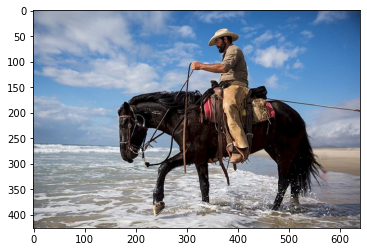

torch.Size([1, 21, 200, 5])
tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0195, 0.0121, 0.8325, 0.1498, 0.9729],
          [0.0115, 0.4305, 0.2309, 0.5102, 0.3969],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0670, 0.7310, 0.7857, 0.8504, 0.9431],
          [0.0482, 0.2568, 0.3209, 0.8609, 0.9024],
          [0.0235, 0.2334, 0.4086, 0.3535, 0.7434],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.00

In [196]:
from utils.ssd_model import DataTransform

# 1. 이미지 읽기
image_file_path = "./data/cowboy-757575_640.jpg"
img = cv2.imread(image_file_path)  # [높이][폭][색BGR]
height, width, channels = img.shape  # 이미지 크기 취득

# 2. 원본 이미지 표시
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 3. 전처리 클래스 작성
color_mean = (104, 117, 123)  # (BGR)색의 평균값
input_size = 300  # 이미지의 input 크기를 300x300으로 설정
transform = DataTransform(input_size, color_mean)

# 4. 전처리
phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, "", "")  # 어노테이션은 없어 ""으로 설정
img = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)

# 5. SSD로 예측
net.eval()  # 네트워크를 추론 모드로
x = img.unsqueeze(0)  # 미니 배치화：torch.Size([1, 3, 300, 300])
detections = net(x)

print(detections.shape)
print(detections)

# output : torch.Size([batch_num, 21, 200, 5])
# = (batch_num, 클래스, conf의 top200, 규격화된 BBox 정보)
# 규격화된 BBox 정보(신뢰도, xmin, ymin, xmax, ymax)

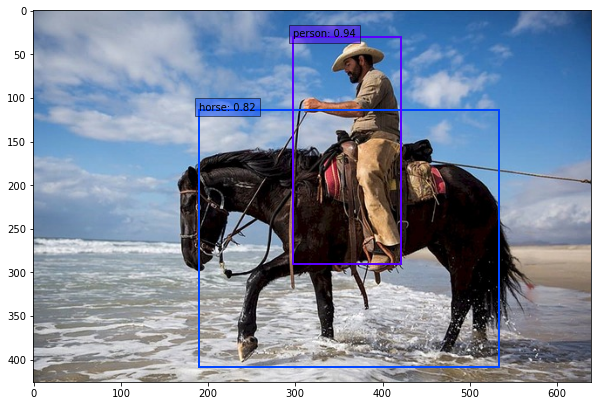

In [197]:
# 이미지 예측
from utils.ssd_predict_show import SSDPredictShow

# 파일 경로
image_file_path = "./data/cowboy-757575_640.jpg"

# 예측 및 결과를 이미지로 그린다
ssd = SSDPredictShow(eval_categories=voc_classes, net=net)
ssd.show(image_file_path, data_confidence_level=0.6)